# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [1]:
!git clone https://github.com/DS3001/assignment4.git

Cloning into 'assignment4'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (8/8), 265.63 KiB | 2.41 MiB/s, done.


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

## 1 work

In [3]:
cars = pd.read_csv("assignment4/data/cars_hw.csv")

In [4]:
cars.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [5]:
cars.dtypes

Unnamed: 0            int64
Make                 object
Make_Year             int64
Color                object
Body_Type            object
Mileage_Run           int64
No_of_Owners         object
Seating_Capacity      int64
Fuel_Type            object
Transmission         object
Transmission_Type    object
Price                 int64
dtype: object

In [6]:
cars["Unnamed: 0"]

0        1
1        2
2        3
3        4
4        5
      ... 
971    972
972    973
973    974
974    975
975    976
Name: Unnamed: 0, Length: 976, dtype: int64

It looks like the "Unnamed: 0" column is just an index, so I'll drop it.

In [7]:
cars.drop("Unnamed: 0", axis=1, inplace=True)

Now I'll examine the variables to see which are categorical and which are numeric. Mileage_Run and Price are continuous numerical variables, so they may be prone to outliers. However, Seating_Capacity and Make_Year only have a few possible values (they are discrete numerical variables). Although Seating_Capacity appears to have some outliers from its box plot, this really just means that the 5-seat arrangement occurs much more frequently than other seating arrangements. Each unique value is a specific type of seating arrangement in a car, which I think is valuable information to preserve.

In [8]:
cars["Make_Year"].unique()

array([2017, 2016, 2019, 2012, 2021, 2020, 2013, 2022, 2018, 2014, 2011,
       2015])

In [9]:
cars["Seating_Capacity"].unique()

array([5, 7, 8, 6, 4])

<Axes: >

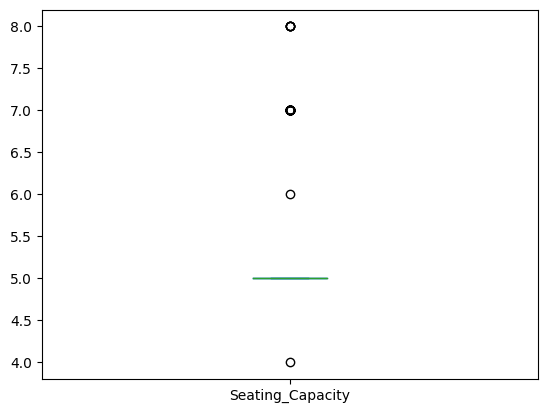

In [10]:
cars["Seating_Capacity"].plot.box()

I'll examine Mileage_Run and Price to see if they need to be scaled or have outliers removed.

<Axes: >

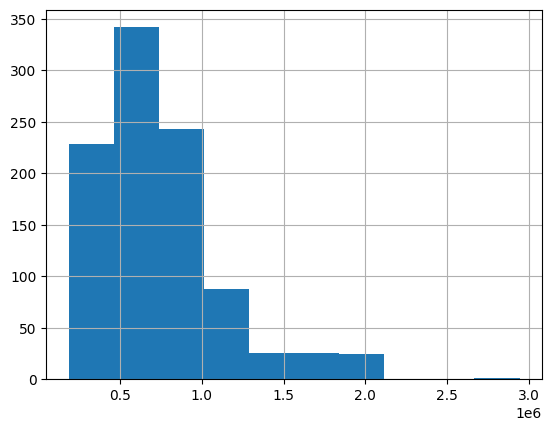

In [11]:
cars["Price"].hist()

<Axes: >

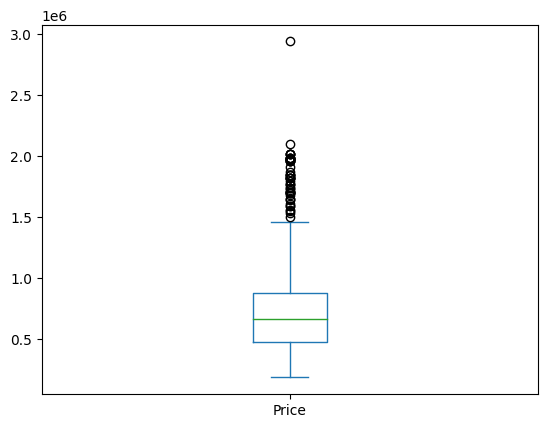

In [12]:
cars["Price"].plot.box()

<Axes: >

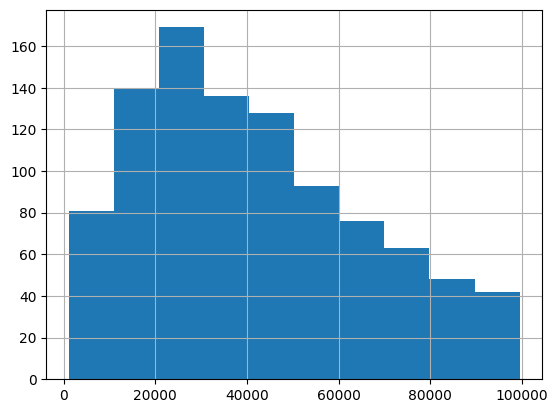

In [13]:
cars["Mileage_Run"].hist()

<Axes: >

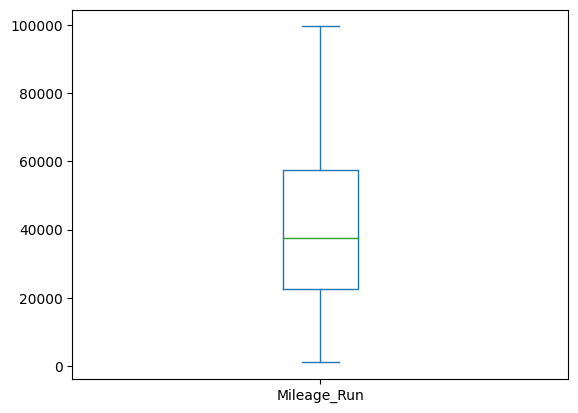

In [14]:
cars["Mileage_Run"].plot.box()

The Mileage_Run histogram doesn't have super long tails, and its boxplot shows that it doesn't have any outliers, so I won't adjust that variable. However, the Price variable has many outliers and a long tail on the right side of the histogram, so I will scale that variable and deal with any remaining outliers.

<Axes: >

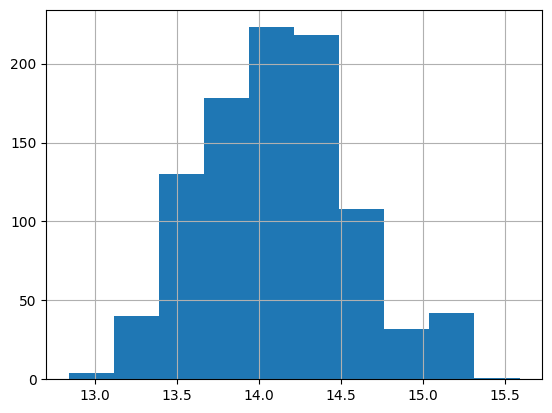

In [15]:
cars["Price_Scaled"] = np.arcsinh(cars["Price"])
cars["Price_Scaled"].hist()

<Axes: >

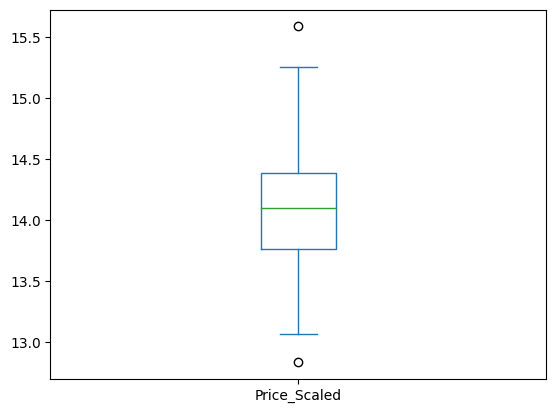

In [16]:
cars["Price_Scaled"].plot.box()

Now, I'll windsorize the outliers.

<Axes: >

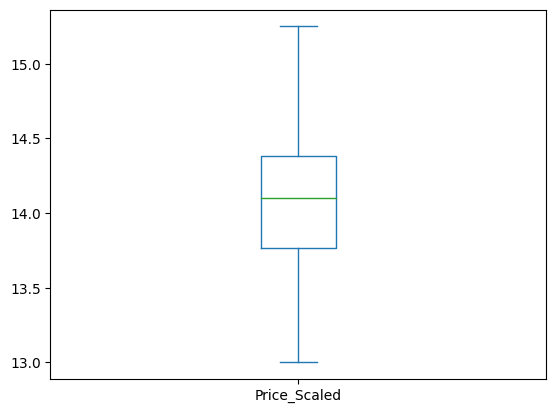

In [17]:
cars.loc[cars["Price_Scaled"] < 13, "Price_Scaled"] = 13
cars.loc[cars["Price_Scaled"] > 15.25, "Price_Scaled"] = 15.25
cars["Price_Scaled"].plot.box()

<Axes: xlabel='Make_Year', ylabel='Price'>

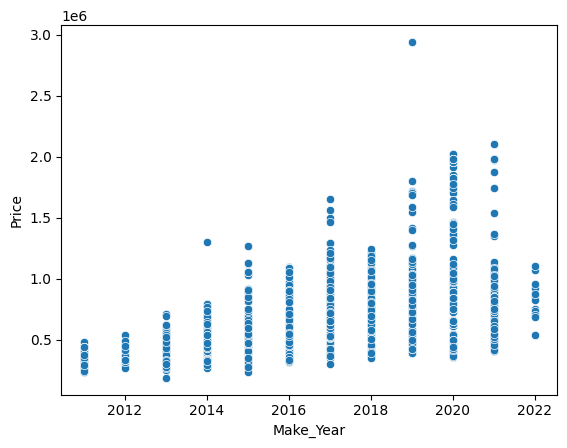

In [18]:
sns.scatterplot(data=cars, y="Price", x="Make_Year")

<Axes: xlabel='Make_Year', ylabel='Price_Scaled'>

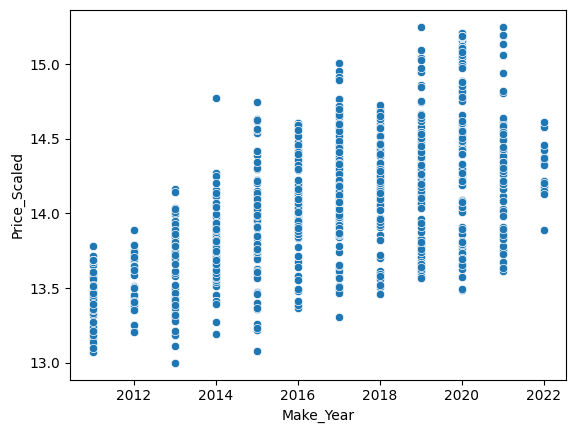

In [19]:
sns.scatterplot(data=cars, y="Price_Scaled", x="Make_Year")

The Price_Scaled variable looks good now! Although the data was already cleaned of null values before I loaded it, I'll just verify that there aren't null values that slipped through the cracks.


In [20]:
cars.isna().sum()

Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
Price_Scaled         0
dtype: int64

In [21]:
cars.isnull().sum()

Make                 0
Make_Year            0
Color                0
Body_Type            0
Mileage_Run          0
No_of_Owners         0
Seating_Capacity     0
Fuel_Type            0
Transmission         0
Transmission_Type    0
Price                0
Price_Scaled         0
dtype: int64

I'm also going to examine the variables to make sure there's no other cleaning I should do.

In [22]:
vars = ["Price", "Price_Scaled", "Color", "Seating_Capacity", "Body_Type", "No_of_Owners",
        "Make", "Make_Year", "Mileage_Run", "Fuel_Type", "Transmission", "Transmission_Type"]

In [23]:
for var in vars:
  print(cars[var].value_counts(), "\n")
  # cars[vars].unique()

790000    8
914000    7
589000    7
812000    6
651000    6
         ..
882000    1
654000    1
634000    1
806000    1
736000    1
Name: Price, Length: 585, dtype: int64 

14.272935    8
13.979329    7
14.418733    7
14.535300    6
14.079412    6
            ..
15.156808    1
14.687640    1
14.383095    1
14.084010    1
14.202133    1
Name: Price_Scaled, Length: 584, dtype: int64 

white     200
red       187
grey      164
silver    132
blue      128
brown      70
black      35
orange     19
bronze     12
beige       9
yellow      6
purple      6
golden      3
maroon      3
green       2
Name: Color, dtype: int64 

5    930
7     39
8      5
6      1
4      1
Name: Seating_Capacity, dtype: int64 

hatchback    484
sedan        227
suv          206
muv           38
crossover     21
Name: Body_Type, dtype: int64 

1st    818
2nd    154
3rd      4
Name: No_of_Owners, dtype: int64 

Hyundai          305
Maruti Suzuki    293
Honda             73
Renault           68
Ford              52
To

The last thing I need to do is convert "No_of_Owners" to a numeric type. We can see that it currently holds strings, but the unique values are only "1st", "2nd", and "3rd", so we can simply truncate each entry and cast it to a numeric type.

In [24]:
print(type(cars["No_of_Owners"][0]))

<class 'str'>


In [25]:
def convert_num_owners(original_value):
  truncated_str = original_value[0]
  return int(truncated_str)

In [26]:
cars['No_of_Owners'] = cars['No_of_Owners'].apply(convert_num_owners)

In [27]:
print(cars['No_of_Owners'].unique())
cars['No_of_Owners'].dtype

[1 2 3]


dtype('int64')

In [28]:
cars.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price,Price_Scaled
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,657000,14.088586
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,682000,14.125932
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,793000,14.276726
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,414000,13.626768
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,515000,13.845069


## 2

2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

For this question, I'm going to use my scaled version of the Price variable, because it will be easier to interpret the values if they don't have a huge range.

In [29]:
cars["Price_Scaled"].describe()

count    976.000000
mean      14.104001
std        0.448823
min       13.000000
25%       13.765795
50%       14.102942
75%       14.384228
max       15.250000
Name: Price_Scaled, dtype: float64

In [30]:
cars.loc[:, ["Price_Scaled", "Make"]].groupby(["Make"]).describe()

Price_Scaled                                             \
                     count       mean       std        min        25%   
Make                                                                    
Chevrolet              6.0  13.613042  0.480975  13.188151  13.261539   
Datsun                 3.0  13.269194  0.036311  13.232114  13.251449   
Ford                  52.0  14.161427  0.210895  13.270783  14.054527   
Honda                 73.0  14.229465  0.336972  13.356645  13.965653   
Hyundai              305.0  14.061658  0.398781  13.114331  13.785051   
Jeep                   4.0  14.909738  0.105084  14.763300  14.876417   
Kia                    8.0  14.985324  0.076877  14.822738  14.965389   
MG Motors             35.0  15.132199  0.066263  14.971763  15.088892   
Mahindra              18.0  14.592100  0.159906  14.280502  14.544955   
Maruti Suzuki        293.0  13.911280  0.371409  13.068963  13.619496   
Nissan                 4.0  14.334341  0.392610  13.764217  14.230922   
Renault               68.0  14.044009  0.331717  13.260385  13.764211   
Skoda                  5.0  14.266529  0.703791  13.678545  13.745088   
Tata                  23.0  14.413598  0.596856  13.000000  14.259530   
Toyota                50.0  14.228654  0.360112  13.508985  13.864561   
Volkswagen            29.0  13.987889  0.203839  13.597355  13.896168   

                                                
                     50%        75%        max  
Make                                            
Chevrolet      13.445433  13.864828  14.394369  
Datsun         13.270783  13.287734  13.304685  
Ford           14.162640  14.269131  14.572571  
Honda          14.266586  14.419827  14.938490  
Hyundai        14.059241  14.330727  15.063692  
Jeep           14.933413  14.966733  15.008827  
Kia            14.996253  15.042662  15.063117  
MG Motors      15.122762  15.190744  15.211260  
Mahindra       14.598828  14.654396  14.890513  
Maruti Suzuki  13.868103  14.239470  14.659661  
Nissan         14.481870  14.585290  14.609408  
Renault        14.068542  14.286754  14.660520  
Skoda          13.888761  14.770252  15.250000  
Tata           14.368246  14.944517  15.250000  
Toyota         14.396608  14.531374  14.596669  
Volkswagen     14.009431  14.150553  14.272935

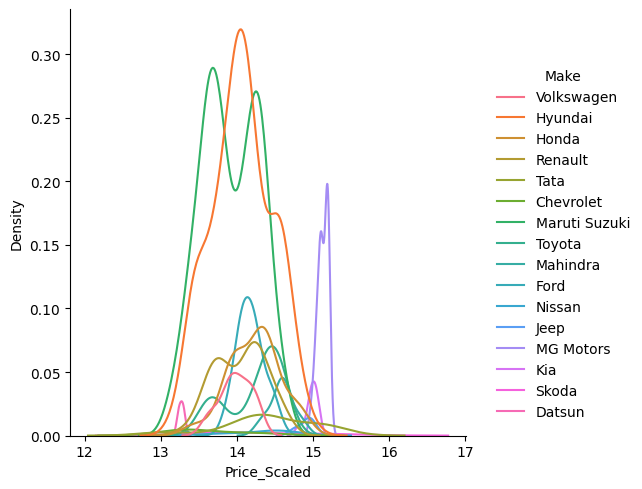

In [31]:
#cars.loc[:, ["Price", "Make"]].groupby(["Make"]).plot.density()
sns.displot(cars, x="Price_Scaled", kind="kde", hue="Make")

TODO -- write about price trends

## 3

3. Split the data into an 80% training set and a 20% testing set.

Before splitting the data into a training and test set, I will create all the additional variables that I need (specifically, the one hot encodings).

In [32]:
num_vars = ["Seating_Capacity", "Make_Year", "Mileage_Run", "No_of_Owners"]
cat_vars = vars = ["Color", "Body_Type", "Make", "Fuel_Type", "Transmission", "Transmission_Type"]

In [33]:
one_hot_encodings = pd.get_dummies(cars[cat_vars],dtype='int')
one_hot_encoding_names = one_hot_encodings.columns

print(one_hot_encoding_names)
print(one_hot_encodings.shape)

Index(['Color_beige', 'Color_black', 'Color_blue', 'Color_bronze',
       'Color_brown', 'Color_golden', 'Color_green', 'Color_grey',
       'Color_maroon', 'Color_orange', 'Color_purple', 'Color_red',
       'Color_silver', 'Color_white', 'Color_yellow', 'Body_Type_crossover',
       'Body_Type_hatchback', 'Body_Type_muv', 'Body_Type_sedan',
       'Body_Type_suv', 'Make_Chevrolet', 'Make_Datsun', 'Make_Ford',
       'Make_Honda', 'Make_Hyundai', 'Make_Jeep', 'Make_Kia', 'Make_MG Motors',
       'Make_Mahindra', 'Make_Maruti Suzuki', 'Make_Nissan', 'Make_Renault',
       'Make_Skoda', 'Make_Tata', 'Make_Toyota', 'Make_Volkswagen',
       'Fuel_Type_diesel', 'Fuel_Type_petrol', 'Fuel_Type_petrol+cng',
       'Transmission_4-Speed', 'Transmission_5-Speed', 'Transmission_6-Speed',
       'Transmission_7-Speed', 'Transmission_CVT',
       'Transmission_Type_Automatic', 'Transmission_Type_Manual'],
      dtype='object')
(976, 46)


In [34]:
cars = pd.concat([cars, one_hot_encodings], axis = 1)
cars.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,...,Fuel_Type_diesel,Fuel_Type_petrol,Fuel_Type_petrol+cng,Transmission_4-Speed,Transmission_5-Speed,Transmission_6-Speed,Transmission_7-Speed,Transmission_CVT,Transmission_Type_Automatic,Transmission_Type_Manual
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,...,1,0,0,0,0,0,1,0,1,0
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,...,0,1,0,0,1,0,0,0,0,1
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,...,0,1,0,0,1,0,0,0,0,1
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,...,0,1,0,0,1,0,0,0,0,1
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,...,0,1,0,0,1,0,0,0,0,1


Now I can go ahead and split the dataset.

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
y = cars["Price_Scaled"]
X = cars.drop(["Price", "Price_Scaled"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## 4

4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by how much?

Now I'll make a model that uses only the numeric variables:

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
num_X_train = X_train.loc[:, num_vars]
num_X_test = X_test.loc[:, num_vars]
num_reg = LinearRegression().fit(num_X_train, y_train)

num_R_squared = num_reg.score(num_X_test, y_test)

num_y_hat = num_reg.predict(num_X_test)
num_SSE = np.sum( (y_test-num_y_hat)**2 )
num_RMSE = (num_SSE/len(y_test))**(1/2)

print("R^2: ", num_R_squared)
print("RMSE: ", num_RMSE)

R^2:  0.37698391421613886
RMSE:  0.34469015043290263


Next, I'll make a model that uses the categorical variables (using one-hot encodings):

In [39]:
cat_X_train = X_train.loc[:, one_hot_encoding_names]
cat_X_test = X_test.loc[:, one_hot_encoding_names]
cat_reg = LinearRegression().fit(cat_X_train, y_train)

cat_R_squared = cat_reg.score(cat_X_test, y_test)

cat_y_hat = cat_reg.predict(cat_X_test)
cat_SSE = np.sum( (y_test-cat_y_hat)**2 )
cat_RMSE = (cat_SSE/len(y_test))**(1/2)

print("R^2: ", cat_R_squared)
print("RMSE: ", cat_RMSE)

R^2:  0.6313712971952382
RMSE:  0.2651391243124503


Finally, I'll make a model that uses all the variables.

In [40]:
# I can't just use the full cars df because it includes the non-encoded categorical variables
# so I'll concatenate the columns from the categorical and numerical datasets
combined_X_train = pd.concat([num_X_train, cat_X_train], axis=1)
combined_X_test = pd.concat([num_X_test, cat_X_test], axis=1)
combined_reg = LinearRegression().fit(combined_X_train, y_train)

combined_R_squared = combined_reg.score(combined_X_test, y_test)

combined_y_hat = combined_reg.predict(combined_X_test)
combined_SSE = np.sum( (y_test-combined_y_hat)**2 )
combined_RMSE = (combined_SSE/len(y_test))**(1/2)

print("R^2: ", combined_R_squared)
print("RMSE: ", combined_RMSE)

R^2:  0.8161776382532859
RMSE:  0.18723128346896736


TODO -- writeup

## 5

5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?

In [41]:
from sklearn.preprocessing import PolynomialFeatures

In [42]:
def polynomial_expansion(X_train, X_test, degree=2):
  # This code adapted from model_evaluation notebook on DS3001 GitHub
  expander = PolynomialFeatures(degree=degree, include_bias=False)

  Z_train = expander.fit_transform(X_train)
  names = expander.get_feature_names_out()
  X_train_expanded = pd.DataFrame(data=Z_train, columns = names)

  Z_test = expander.fit_transform(X_test)
  names = expander.get_feature_names_out()
  X_test_expanded = pd.DataFrame(data=Z_test, columns = names)

  return X_train_expanded, X_test_expanded

In [18]:
def evaluate_linear_model(X_train, X_test, y_train, y_test):
  # Fit the model and get the R2 measure:
  reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
  print(reg.score(X_test, y_test)) # R squared measure

  # Predicted values:
  y_hat = reg.predict(X_test)
  residuals_lm = y_test - y_hat

  ## Residual plot:
  sns.kdeplot(residuals_lm)
  plt.show()

  ## True versus predicted plot:
  plt.scatter(x=y_hat,y=y_test)
  plt.title('Predicted vs. Actual Values')
  plt.show()

In [44]:
def expand_and_evaluate_model(degree):
  deg_num_X_train, deg_num_X_test = polynomial_expansion(num_X_train, num_X_test, degree=degree)

  deg_X_train = pd.concat([deg_num_X_train.reset_index(), cat_X_train.reset_index()], axis=1)
  deg_X_test = pd.concat([deg_num_X_test.reset_index(), cat_X_test.reset_index()], axis=1)

  evaluate_linear_model(deg_X_train, deg_X_test, y_train, y_test)

Degree 2

0.8121205328558432


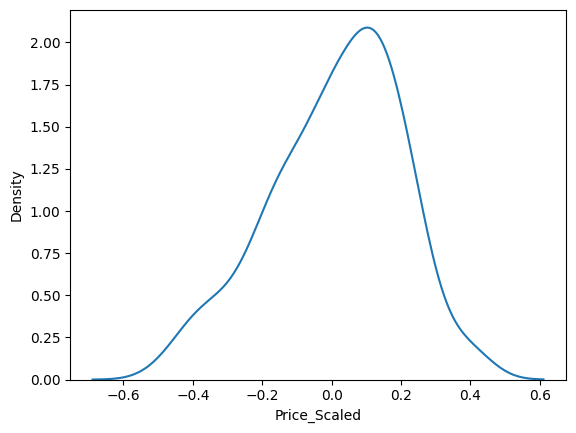

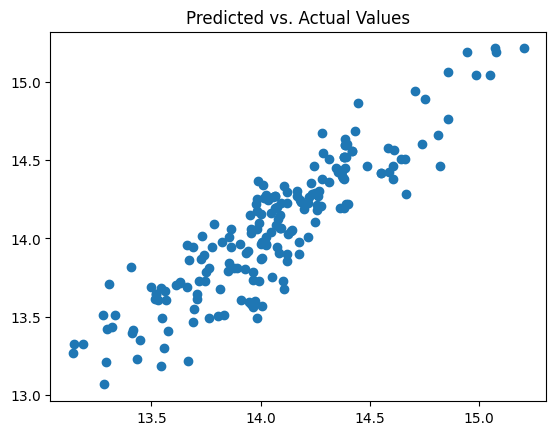

In [ ]:
expand_and_evaluate_model(2)

Degree 3

0.8021816949405629


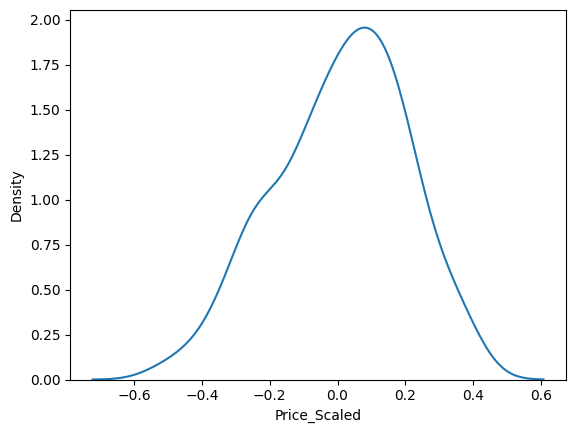

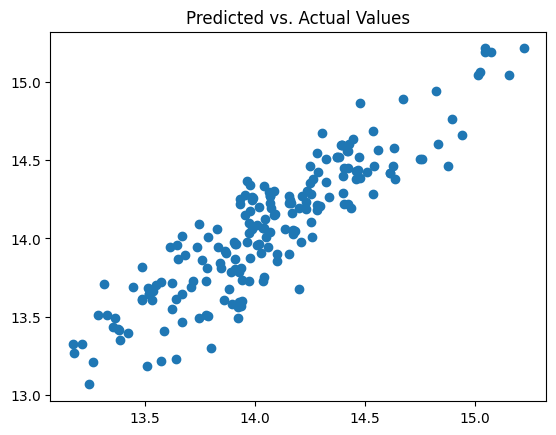

In [ ]:
expand_and_evaluate_model(3)

Degree 4

0.031414581228759286


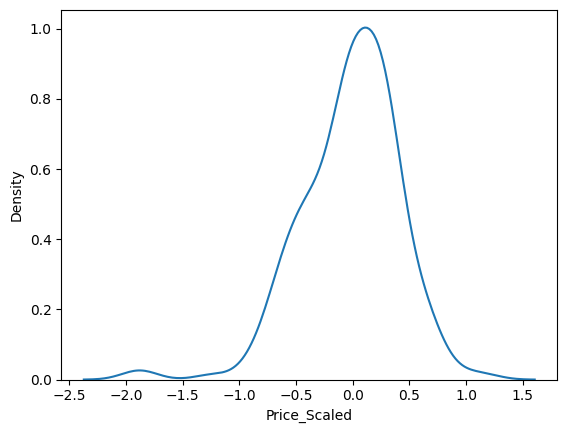

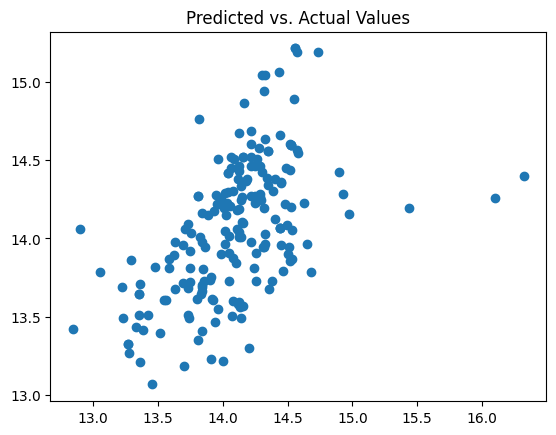

In [ ]:
expand_and_evaluate_model(4)

0.004636677837446257


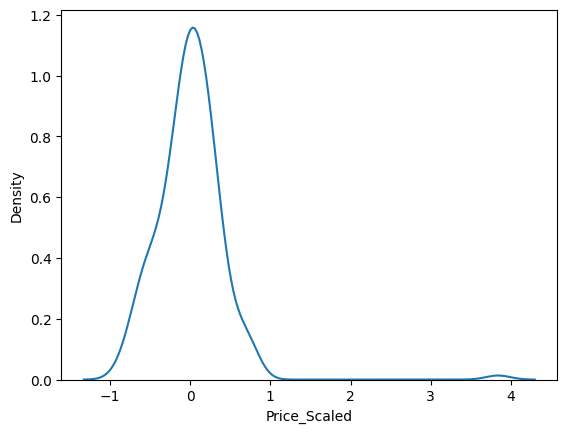

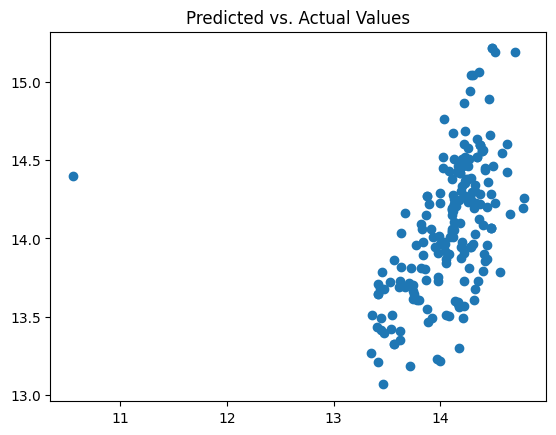

In [ ]:
expand_and_evaluate_model(5)

-0.12144982334630372


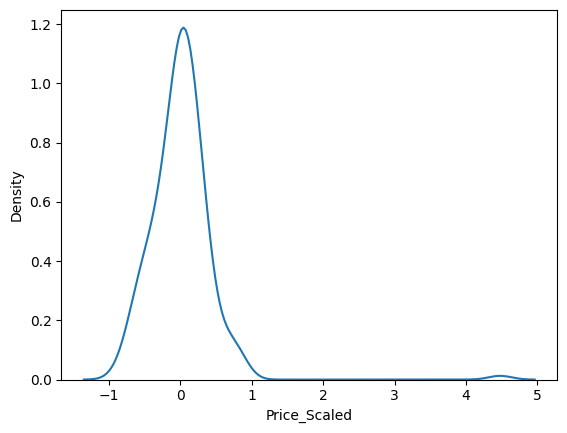

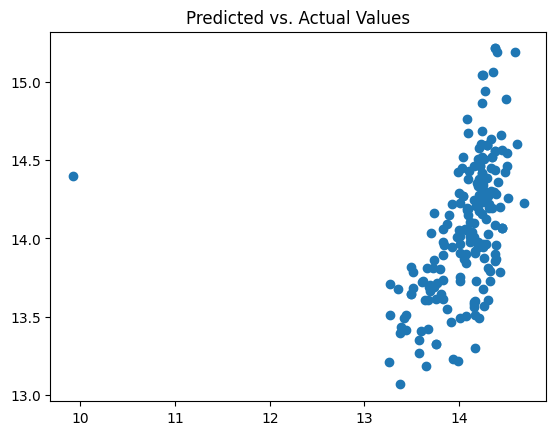

In [ ]:
expand_and_evaluate_model(6)

TODO, make evaluate model func prettier and do write up

## 6

6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

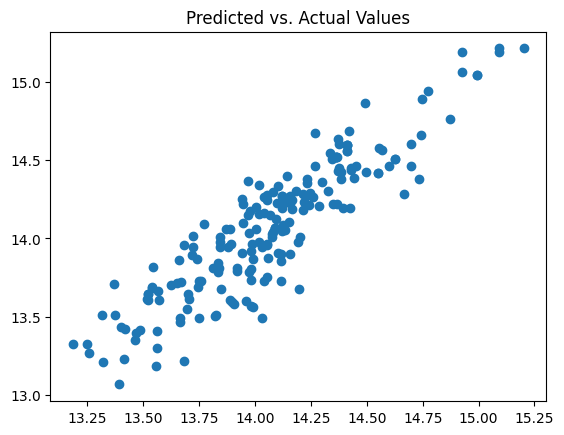

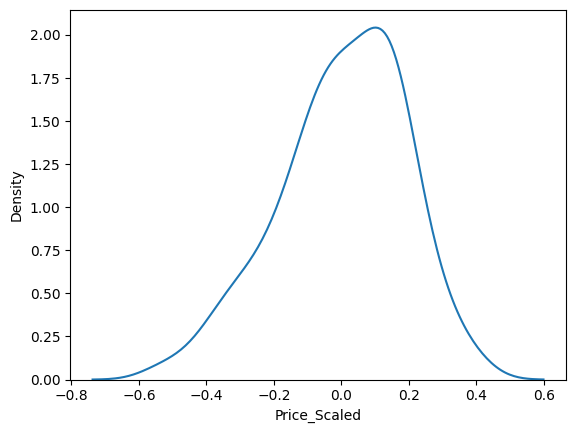

In [45]:
residuals = y_test - combined_y_hat

## True versus predicted plot:
plt.scatter(x=combined_y_hat,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Residual plot:
sns.kdeplot(residuals)
plt.show()

TODO, writeup and making this prettier

## 7

7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the and RMSE on the test set of a variety of depths. What depth tree gives the best results?

In [15]:
from sklearn import tree

In [20]:
def create_tree(X_train, y_train, depth):
  model = tree.DecisionTreeRegressor(max_depth=depth) # Fit the regressor
  cart = model.fit(X_train, y_train)
  tree.plot_tree(cart,filled=True)
  plt.show()
  return cart

def evaluate_tree(X_test, y_train, y_test, trained_model):
  ## Make Predictions on the Test Set
  y_hat_cart = trained_model.predict(X_test)
  residuals_cart = y_test - y_hat_cart

  ## Residual plot:
  sns.kdeplot(residuals_cart)
  plt.show()

  ## True versus predicted plot:
  plt.scatter(x=y_hat_cart,y=y_test)
  plt.title('Predicted vs. Actual Values')
  plt.show()

  ## Metrics:
  SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
  MSE_cart = (1/len(y_test))*np.sum( (y_test-y_hat_cart)**2 )
  RMSE_cart = (SSE_cart/len(y_test))**(1/2)
  TSS = np.sum( (y_test - y_train.mean())**2 )
  R2_cart = 1 - SSE_cart/TSS
  print("RMSE: ", RMSE_cart)
  print("R^2: ", R2_cart)

Max depth = 5

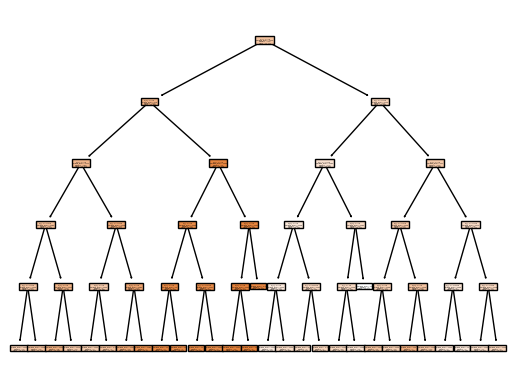

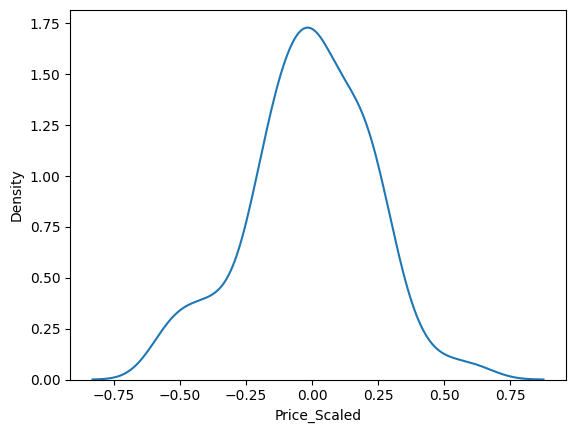

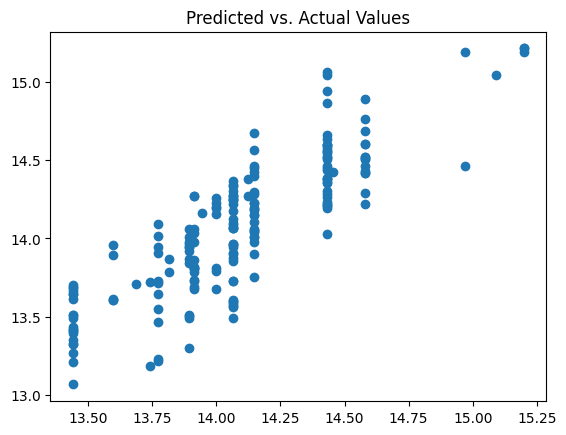

RMSE:  0.232820406887273
R^2:  0.7181737502846033


In [58]:
cart_5 = create_tree(combined_X_train, y_train, 5)
evaluate_tree(combined_X_test, y_train, y_test, cart_5)

Max depth = 7

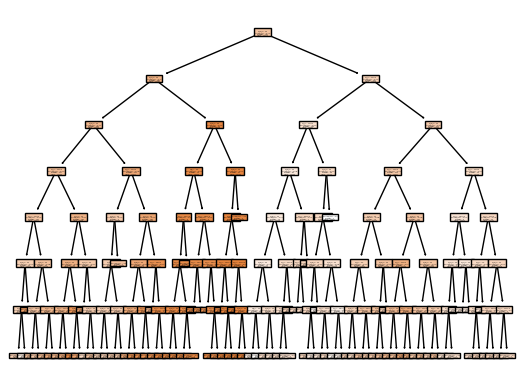

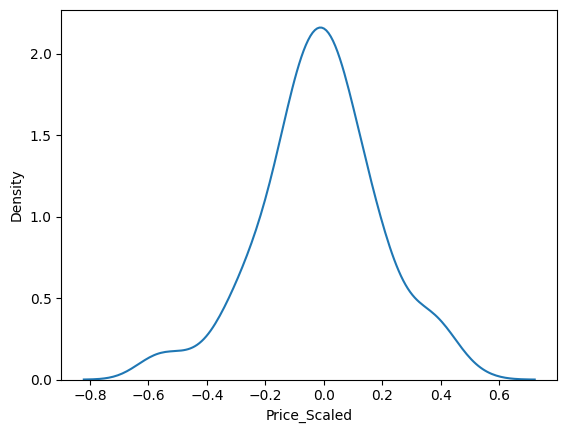

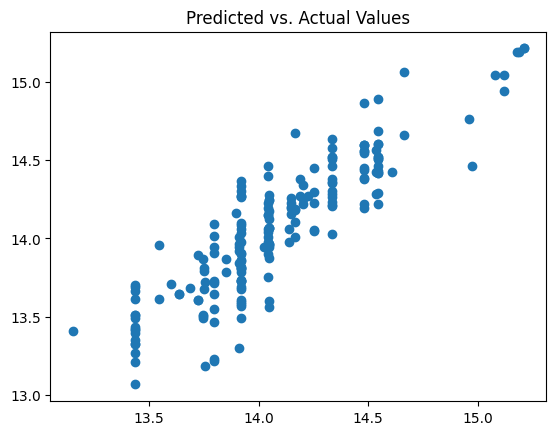

RMSE:  0.20447050660761767
R^2:  0.7826294522488271


In [63]:
cart_7 = create_tree(combined_X_train, y_train, 7)
evaluate_tree(combined_X_test, y_train, y_test, cart_7)

Max depth = 8

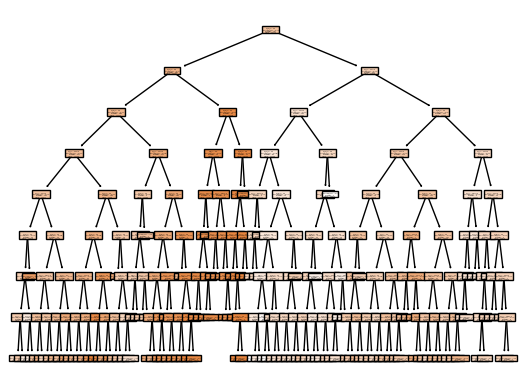

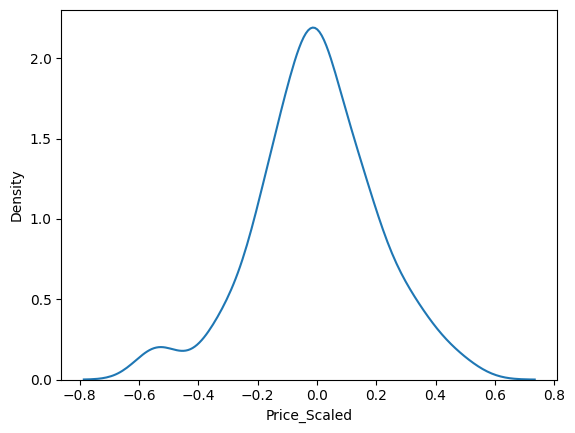

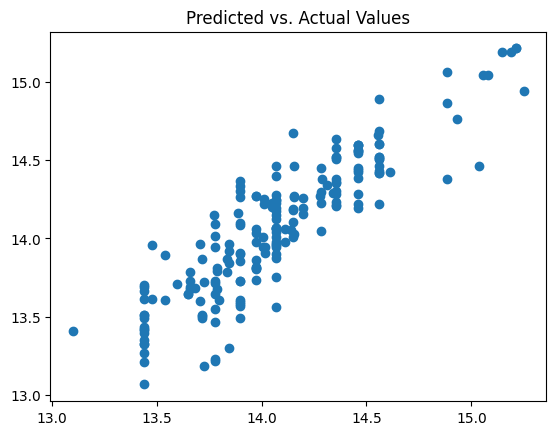

RMSE:  0.20332490520271343
R^2:  0.7850583835210158


In [62]:
cart_8 = create_tree(combined_X_train, y_train, 8)
evaluate_tree(combined_X_test, y_train, y_test, cart_8)

Max depth = 9

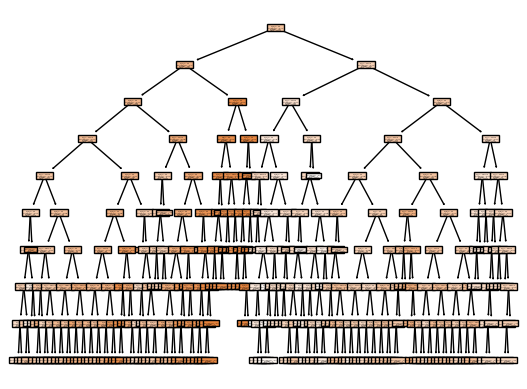

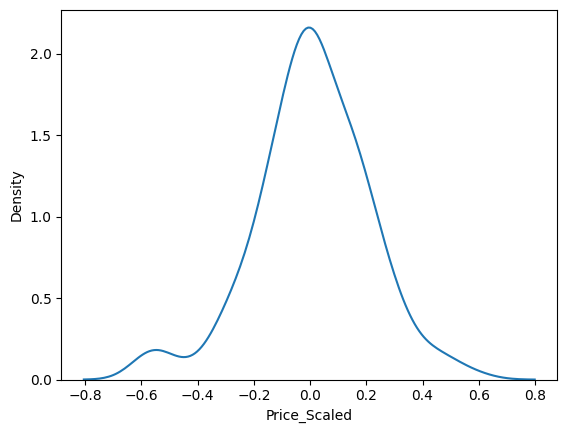

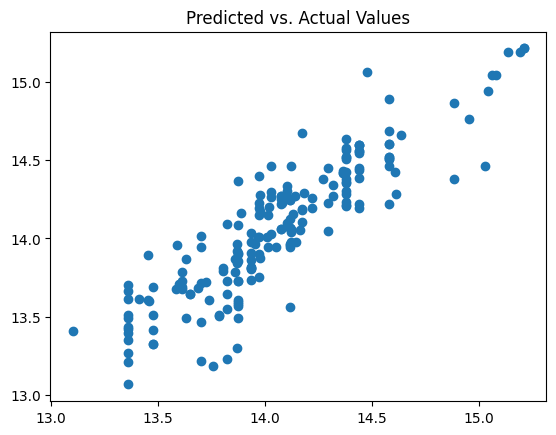

RMSE:  0.20333584536499366
R^2:  0.7850352524695061


In [64]:
cart_9 = create_tree(combined_X_train, y_train, 9)
evaluate_tree(combined_X_test, y_train, y_test, cart_9)

Max depth = 10

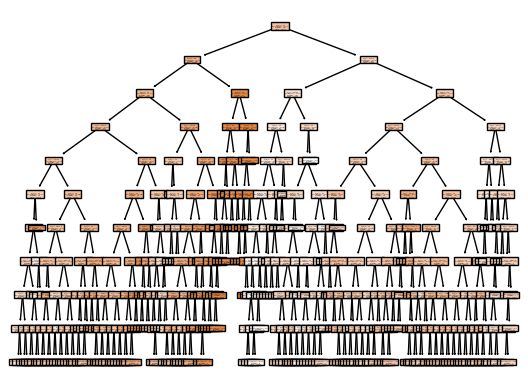

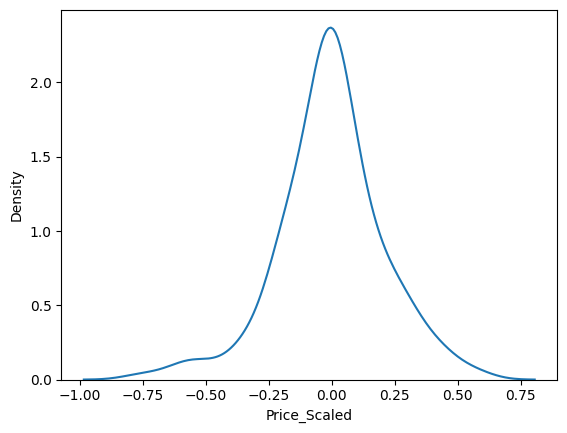

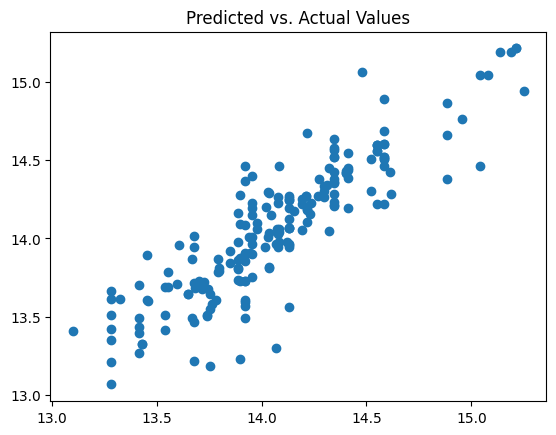

RMSE:  0.210099749823723
R^2:  0.7704959127847448


In [59]:
cart_10 = create_tree(combined_X_train, y_train, 10)
evaluate_tree(combined_X_test, y_train, y_test, cart_10)

Max depth = 20

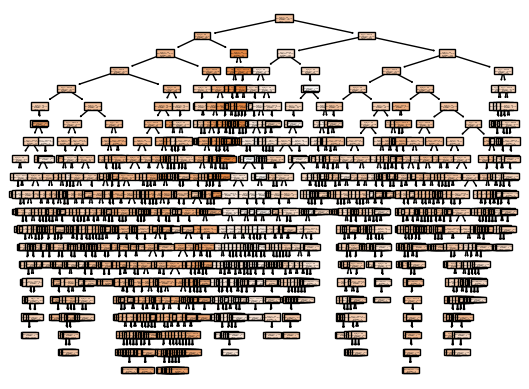

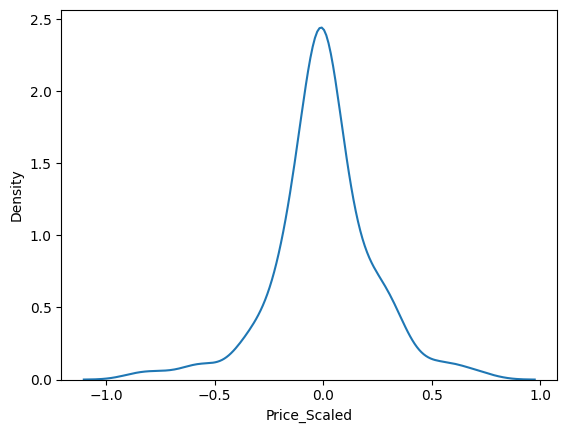

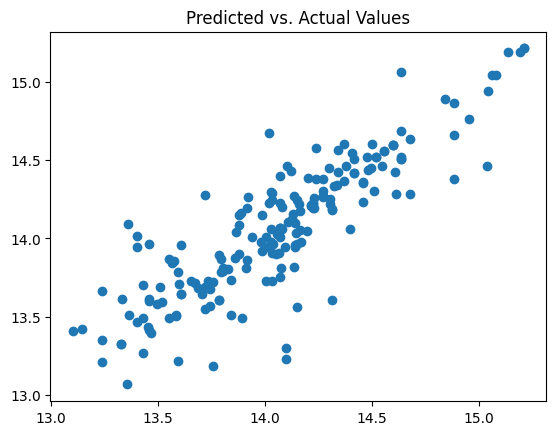

RMSE:  0.2284415740581962
R^2:  0.7286751062230362


In [61]:
cart_20 = create_tree(combined_X_train, y_train, 20)
evaluate_tree(combined_X_test, y_train, y_test, cart_20)

## 8

8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

The best tree was the one with a max depth of 8. I've already computed its residuals, graphed the true and predicted values, and created a kernel density plot, but I will do it again here for easier grading.

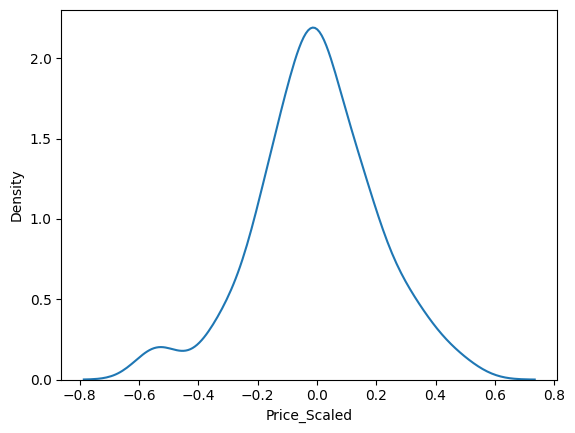

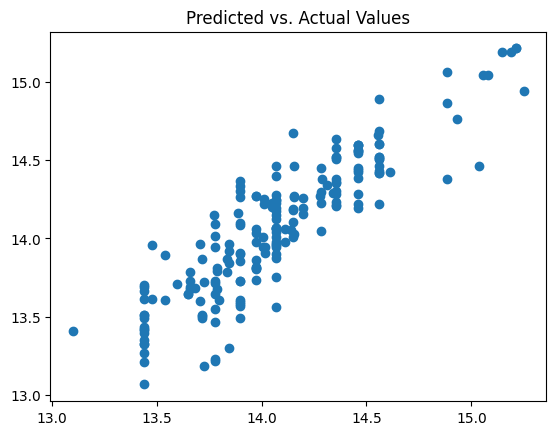

RMSE:  0.20332490520271343
R^2:  0.7850583835210158


In [65]:
evaluate_tree(combined_X_test, y_train, y_test, cart_8)

## 9

9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

The best linear model achieved an RMSE of 0.1872 on the test set, while the best regression tree achieved an RMSE of 0.2033. Thus, the linear model performed better on the test set.

# 3

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?

In [5]:
bc = pd.read_csv("./assignment4/data/contraception_hw.csv")

In [6]:
bc["method"].value_counts()

1    629
3    511
2    333
Name: method, dtype: int64

In [7]:
pd.crosstab(bc["method"], bc["numberChildren"])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


It seems as though couples that use long term birth control tend to have a few children, usualy around 2-4. Meanwhile, couples that use short-term birth control also tend to have about 2-4 children, but the distribution has a longer tail (more couples that use short-term birth control have higher numbers of children). Interestingly, couples that don't use any birth control are the most likely to have zero children or just 1-2 children. Perhaps this includes couples who are abstinent.

  2. Split the sample into ~80% training data and ~20% testing data.

In [11]:
from sklearn.model_selection import train_test_split

In [8]:
bc.head()

,Unnamed: 0,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure,method
0,1,24,2,3,3,1,1,2,3,0,1
1,2,45,1,3,10,1,1,3,4,0,1
2,3,43,2,3,7,1,1,3,4,0,1
3,4,42,3,2,9,1,1,3,3,0,1
4,5,36,3,3,8,1,1,3,2,0,1


In [9]:
y = bc["method"]
X = bc.drop(["method", "Unnamed: 0"], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

 3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

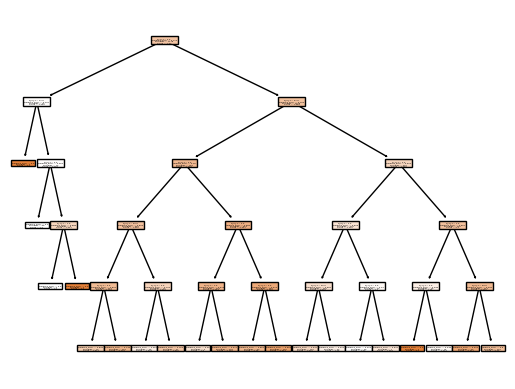

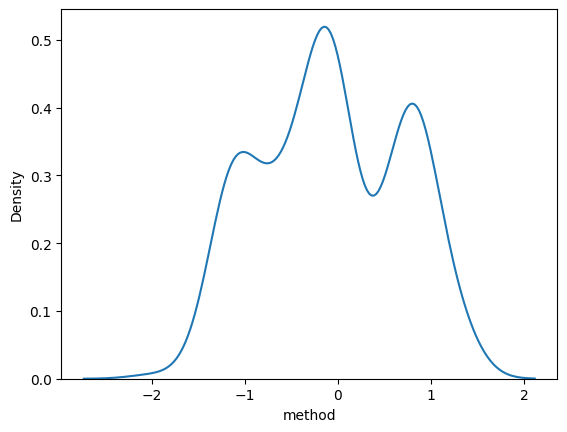

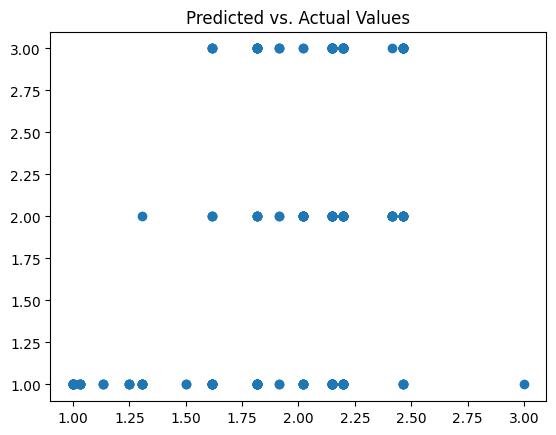

RMSE:  0.7597826033715986
R^2:  0.22740023944488275


In [21]:
bc_regression_tree = create_tree(X_train, y_train, 5)
evaluate_tree(X_test, y_train, y_test, bc_regression_tree)

I can't really see what's going on in the final nodes, so I'll print the tree out in text format.

In [24]:
print(tree.export_text(bc_regression_tree))

|--- feature_3 <= 0.50
|   |--- feature_0 <= 17.50
|   |   |--- value: [3.00]
|   |--- feature_0 >  17.50
|   |   |--- feature_6 <= 3.50
|   |   |   |--- value: [1.00]
|   |   |--- feature_6 >  3.50
|   |   |   |--- feature_1 <= 1.50
|   |   |   |   |--- value: [1.00]
|   |   |   |--- feature_1 >  1.50
|   |   |   |   |--- value: [3.00]
|--- feature_3 >  0.50
|   |--- feature_0 <= 37.50
|   |   |--- feature_3 <= 2.50
|   |   |   |--- feature_0 <= 30.50
|   |   |   |   |--- feature_1 <= 2.50
|   |   |   |   |   |--- value: [1.81]
|   |   |   |   |--- feature_1 >  2.50
|   |   |   |   |   |--- value: [2.15]
|   |   |   |--- feature_0 >  30.50
|   |   |   |   |--- feature_1 <= 3.50
|   |   |   |   |   |--- value: [1.31]
|   |   |   |   |--- feature_1 >  3.50
|   |   |   |   |   |--- value: [1.91]
|   |   |--- feature_3 >  2.50
|   |   |   |--- feature_6 <= 2.50
|   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |--- value: [1.50]
|   |   |   |   |--- feature_2 >  1.50
|   |   |   

The variable that we're predicting, which is the birth control method, only has three discrete values: 1, 2, and 3. But, looking at the tree that was generated, it turns out that this regressor predicted non-discrete values for the method variable, which doesn't make sense! A value of 1.13 for the method, for example, has no real meaning. You either use birth control, or you don't -- you can't have an in-between value. What went wrong here is that I created a regressor, not a classifier, so the tree was not trying to sort samples into the three separate categories, but rather treated "method" as a continuous numerical variable that it could predict.

 4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

In [120]:
X.head()

,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0


In [22]:
def create_classification_tree(X_train, y_train, depth, num_features=None):
  model = tree.DecisionTreeClassifier(max_depth=depth, max_features=num_features)
  cart = model.fit(X_train, y_train)
  tree.plot_tree(cart,filled=True)
  plt.show()
  return cart

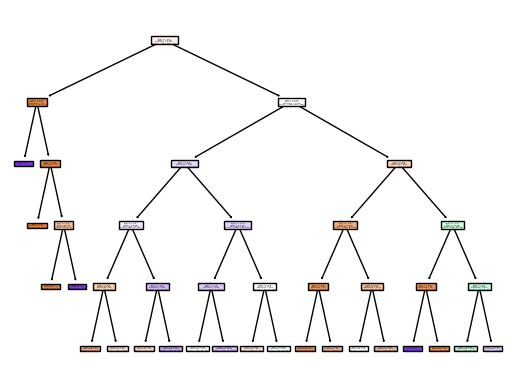

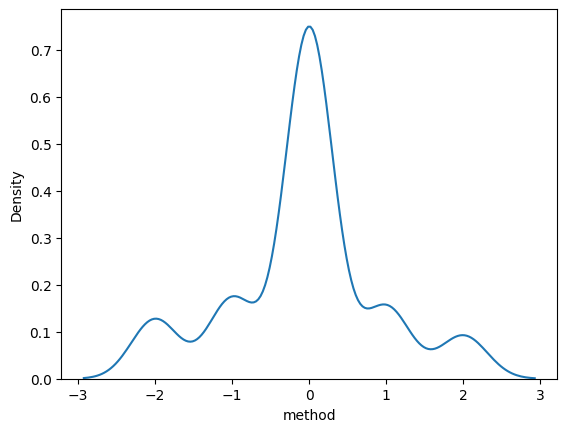

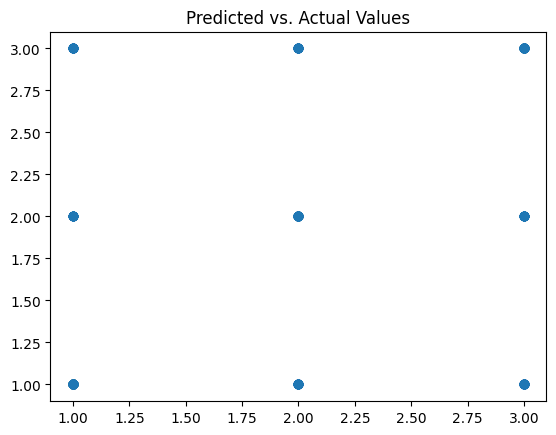

RMSE:  0.9637497389478421
R^2:  -0.2430953025764382


In [23]:
bc_classification_tree = create_classification_tree(X_train, y_train, 5)
evaluate_tree(X_test, y_train, y_test, bc_classification_tree)

In [25]:
print(tree.export_text(bc_classification_tree))

|--- feature_3 <= 0.50
|   |--- feature_0 <= 17.50
|   |   |--- class: 3
|   |--- feature_0 >  17.50
|   |   |--- feature_6 <= 3.50
|   |   |   |--- class: 1
|   |   |--- feature_6 >  3.50
|   |   |   |--- feature_1 <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  1.50
|   |   |   |   |--- class: 3
|--- feature_3 >  0.50
|   |--- feature_0 <= 37.50
|   |   |--- feature_1 <= 2.50
|   |   |   |--- feature_3 <= 2.50
|   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_5 >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  2.50
|   |   |   |   |--- feature_7 <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_7 >  1.50
|   |   |   |   |   |--- class: 3
|   |   |--- feature_1 >  2.50
|   |   |   |--- feature_0 <= 31.50
|   |   |   |   |--- feature_6 <= 1.50
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_6 >  1.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- feature

This classifier uses feature three (or number of children) as its top-most split, indicating that number of children is the most important factor for predicting whether a couple used birth control -- this makes sense! The model then uses feature 0 (age), followed by features 1 and 6, which correspond to education level and spouse occupation.

Generally, it seems that very young people (17.5 and younger) either use no birth control or short term birth control. Meanwhile, older people (early forties and higher) tend to use no birth control, which makes sense because most people stop being able to have children at that age. People between those ages could use any kind of birth control, with those of greater educational level tending to use birth control more.

5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
y_hat_cart = bc_classification_tree.predict(X_test)
conf_mat = confusion_matrix(y_test, y_hat_cart)
print(conf_mat)

[[77 24 29]
 [12 44 15]
 [21 23 50]]


In [28]:
# total accuracy
accuracy = (conf_mat[0][0] + conf_mat[1][1] + conf_mat[2][2]) / conf_mat.sum()
print(accuracy)

0.5796610169491525


In [30]:
# 1 accuracy
accuracy_1 = (conf_mat[0][0]) / (conf_mat[0][0] + conf_mat[0][1] + conf_mat[0][2])
# 2 accuracy
accuracy_2 = (conf_mat[1][0]) / (conf_mat[1][0] + conf_mat[1][1] + conf_mat[1][2])
# 3 accuracy
accuracy_3 = (conf_mat[2][0]) / (conf_mat[2][0] + conf_mat[2][1] + conf_mat[2][2])

print(accuracy_1)
print(accuracy_2)
print(accuracy_3)

0.5923076923076923
0.16901408450704225
0.22340425531914893


  6. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

We can't use a linear model to do this exercise because there is no linear relationship among the variables. As I saw in the previous parts of the question, there isn't a linear relationship between age and contraceptive method (very old and very young people both used less contraception than people of intermediate age). This seemed to hold true for other variables, too. Thus, using a linear model would make assumptions about the data that aren't true -- it would model the relationships among the variables too simply. Instead, a decision tree is a good choice because it can model non-linear relationships.